# Data prep

I load in the data. Set up the dtypes properly, ditch eleven records, rename a few columns and records

In [2]:
import pandas as pd

df = pd.read_csv("data/lobbying.csv")

# Check the size of the dataset
print(f"Number of records: {len(df)}\n")

print(f"Missing records:\n{df.isna().sum()}\n")

# Drop the missing ones, except "purpose" because that won't be the
# centre of our analysis, but it is kinda interesting
df.dropna(
    subset=["person_id", "member_id", "rep_new", "policy_level", "organisation"],
    inplace=True,
)

# check dtypes and ensure dates are dates and member_id is int
print(f"dtypes{df.dtypes}")

# dates to datetime and member_id to int
df["date"] = pd.to_datetime(df["date"], dayfirst=True)
df["member_id"] = df["member_id"].astype(int)

# tidy the column names, I can't abide capitals in pandas columns
df.columns = [i.lower() for i in df.columns]

# Rename the `organisation` and recordid columns for clarity
df.rename(
    columns={"organisation": "reported_lobbyists", "recordid": "record_id"},
    inplace=True,
)

# Create a uid from a hash of the reported_lobbyists name, because free text merges are icky
df["reported_lobbyists_id"] = df["reported_lobbyists"].apply(hash)

# Fix a capitalisation typo
df["department"].str.replace("Whips' office", "Whips' Office")

Number of records: 102323

Missing records:
RecordId          0
person_id         1
member_id         1
rep_new           1
policy_level      1
date              0
organisation     10
purpose         409
department        0
Year              0
Quarter           0
Period            0
dtype: int64

dtypesRecordId          int64
person_id        object
member_id       float64
rep_new          object
policy_level     object
date             object
organisation     object
purpose          object
department       object
Year              int64
Quarter          object
Period           object
dtype: object


Index(['record_id', 'person_id', 'member_id', 'rep_new', 'policy_level',
       'date', 'reported_lobbyists', 'purpose', 'department', 'year',
       'quarter', 'period', 'reported_lobbyists_id'],
      dtype='object')

# Greensill

In [4]:
df.loc[df["reported_lobbyists"].str.lower().str.contains("greensill")]

,record_id,person_id,member_id,rep_new,policy_level,date,reported_lobbyists,purpose,department,year,quarter,period,reported_lobbyists_id
5569,5570,JgAyn8BZ,4070,Rt Hon Matt Hancock MP,Minister of State,2015-10-19,Greensill Capital,Supply chain finance policy,Cabinet Office,2015,Q4,2015 Q4,622323470249927019


# Setup matplotlib

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams.update(
    {
        "axes.facecolor": "#2B2B2B",  # Cool dark grey background for the plot
        "figure.facecolor": "#2B2B2B",  # Cool dark grey background for the figure
        "axes.edgecolor": "white",  # White edges
        "axes.labelcolor": "white",  # White labels
        "xtick.color": "white",  # White x-tick labels
        "ytick.color": "white",  # White y-tick labels
        "text.color": "white",  # White text
        "savefig.facecolor": "#2B2B2B",  # Background for saved figures
        "savefig.edgecolor": "white",  # Edge color for saved figures
        "axes.titlecolor": "white",  # Title color
        "axes.spines.top": False,
        "axes.spines.right": False,
    }
)

# Basic time series

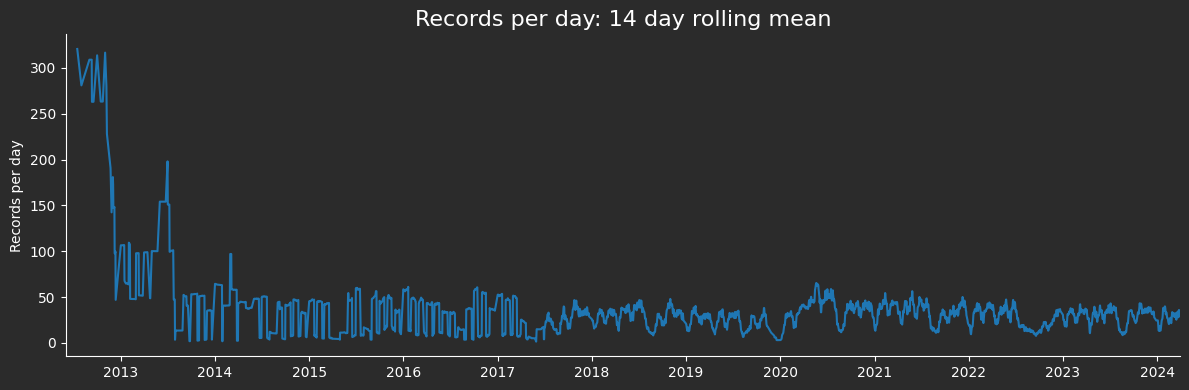

In [6]:
fig, ax = plt.subplots(figsize=(12, 4))
df.groupby("date").size().rolling(14).mean().plot()

ax.set_xlabel("")
ax.set_ylabel("Records per day")

# It's doing angled xticklabels, I'd rather them flat
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

# Set the major ticks for the main plot
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# Crop out the start of 2012 where we have no records
ax.set_xlim("2012-06-01", str(df["date"].max()))

plt.title("Records per day: 14 day rolling mean", fontdict={"size": 16})
plt.tight_layout()
plt.savefig("img/records-day-timeseries-basic.png")

# Closer look: inset version

/tmp/ipykernel_128608/978724495.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


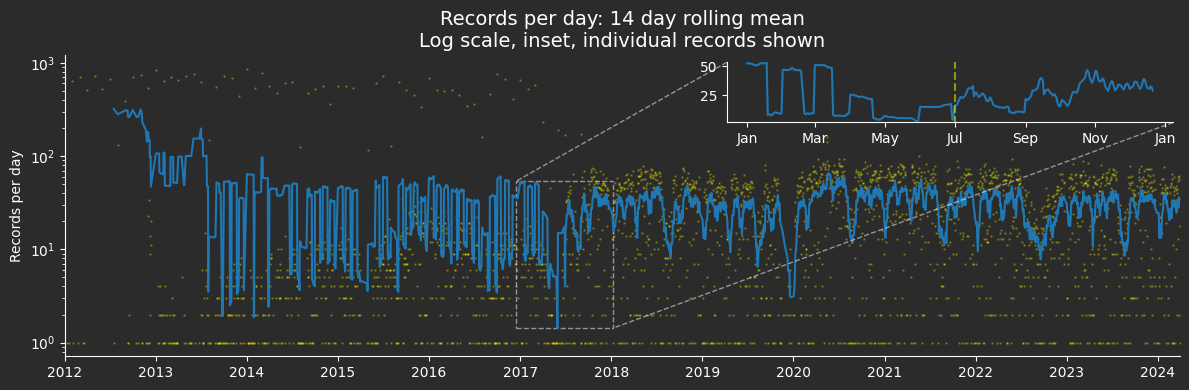

In [7]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 4))

# Main plot

# Plot the 14-day rolling mean
time_series = df.groupby("date").size().rolling(14).mean()
time_series.plot(ax=ax)

# Plot the dots
dot_series = df.groupby("date").size().reset_index()
dot_series.plot.scatter(x="date", y=0, ax=ax, c="yellow", alpha=0.25, s=0.6)

# Set the main plot to a log scale because it looks dumb without
ax.set_yscale("log")

# Set the major ticks for the main plot
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# Set labels for the main plot
ax.set_ylabel("Records per day")
ax.set_xlabel("")

# Crop to the start of 2012 where we have no records
ax.set_xlim("2012-01-01", str(df["date"].max()))

# Inset

# Define the inset
ax_inset = inset_axes(ax, width="40%", height="20%", loc="upper right")

# Plot the zoomed-in region on the inset
zoom_data = time_series.loc[
    (time_series.index >= "2017-01-01") & (time_series.index <= "2017-12-31")
]
zoom_data.plot(ax=ax_inset)

# Set labels and remove the xlabel for the inset
ax_inset.set_xlabel("")

# Set the major ticks for the months on the inset plot
ax_inset.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax_inset.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

# Set minor ticks for the year on the inset
ax_inset.xaxis.set_minor_locator(mdates.YearLocator())
ax_inset.xaxis.set_minor_formatter(mdates.DateFormatter("\n%Y"))

# Put a vline at the discontinuity
ax_inset.vlines("2017-07-01", 0, 200, colors="yellow", linestyles="--", alpha=0.5)

# Set the y-limits for the inset to zoom in
ax_inset.set_ylim(zoom_data.min(), zoom_data.max())

# Indicate the zoomed region using mark_inset
mark_inset(
    ax, ax_inset, loc1=2, loc2=4, fc="none", ec="white", alpha=0.5, linestyle="--"
)

# Globals

# Rotate tick labels for better readability
plt.setp(ax_inset.get_xticklabels(), rotation=0, ha="center")
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

ax.set_title(
    "Records per day: 14 day rolling mean\nLog scale, inset, individual records shown",
    fontdict={"size": 14},
)

plt.tight_layout()
plt.savefig("img/records-day-timeseries-advanced-inset.png")

# Closer look: no inset

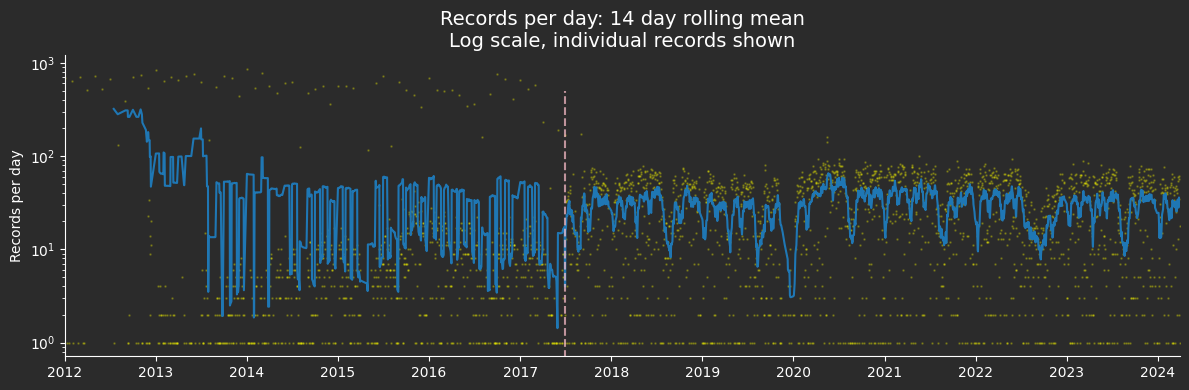

In [8]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 4))

# Main plot

# Plot the 14-day rolling mean
time_series = df.groupby("date").size().rolling(14).mean()
time_series.plot(ax=ax)

# Plot the dots
dot_series = (
    df.groupby("date")
    .size()
    .reindex(pd.date_range(df["date"].min(), df["date"].max()))
    .reset_index()
    .fillna(0)
    .rename(columns={"index": "date", 0: "values"})
)
dot_series.plot.scatter(x="date", y="values", ax=ax, c="yellow", alpha=0.25, s=0.6)

# Set the main plot to a log scale because it looks dumb without
ax.set_yscale("log")

# Set the major ticks for the main plot
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# Set labels for the main plot
ax.set_ylabel("Records per day")
ax.set_xlabel("")

# Put a vline at the discontinuity
ax.vlines("2017-07-01", 0, 500, colors="pink", linestyles="--", alpha=0.7)

# Globals

# Rotate tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

ax.set_title(
    "Records per day: 14 day rolling mean\nLog scale, individual records shown",
    fontdict={"size": 14},
)

# Crop to the start of 2012 where we have no records
ax.set_xlim("2012-01-01", str(df["date"].max()))

plt.tight_layout()
plt.savefig("img/records-day-timeseries-advanced.png")

# Look at top reporter/day pairs

In [9]:
top_days = df.groupby(["date", "rep_new"]).size().sort_values(ascending=False).head(10)
print(top_days)

date        rep_new                   
2016-10-01  Mr Robin Walker MP            232
2014-01-01  Rt Hon Esther McVey MP        151
2014-07-01  Rt Hon Alun Cairns MP         108
2012-03-01  Rt Hon Chris Grayling MP      101
2012-02-01  Rt Hon Chris Grayling MP       97
2013-04-01  Mr Mark Hoban                  79
2014-03-01  Rt Hon Esther McVey MP         78
2013-03-01  Mr Mark Hoban                  78
2012-10-01  Mr Mark Hoban                  68
2014-03-01  The Rt Hon. the Lord Freud     66
dtype: int64


# Proportion of meetings on first day of month

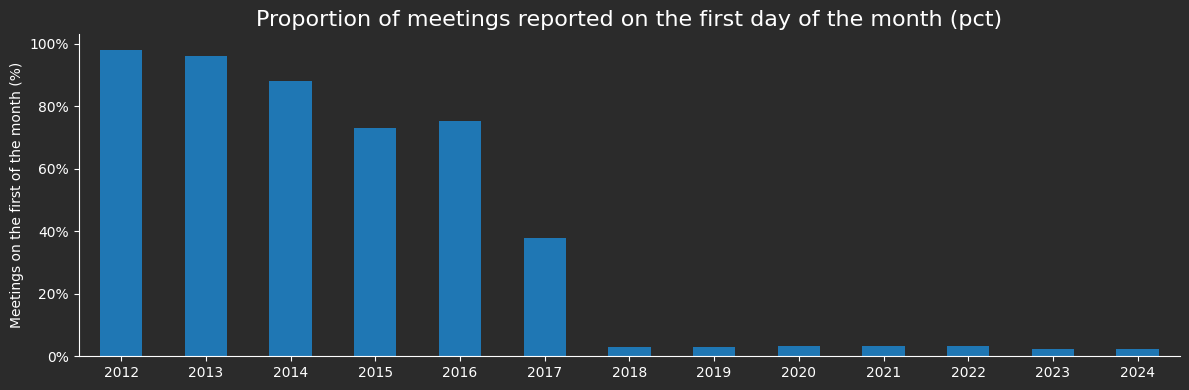

In [10]:
import matplotlib.ticker as mtick

# Work out whether a meeting is on the first day of the month
df["week_day"] = df["date"].dt.day
df["first_day"] = df["week_day"] == 1

# Define the plot
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the pct of meetings on the first day
df.groupby("year")["first_day"].mean().plot.bar(ax=ax)

# Set the axis labels
ax.set_xlabel("")
ax.set_ylabel("Meetings on the first of the month (%)")

# Set axis tick formatting
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Set title
ax.set_title(
    "Proportion of meetings reported on the first day of the month (pct)",
    fontdict={"size": 16},
)

# Rotate tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")


plt.tight_layout()
plt.savefig("img/records-first-day.png")

# Length of reports over time

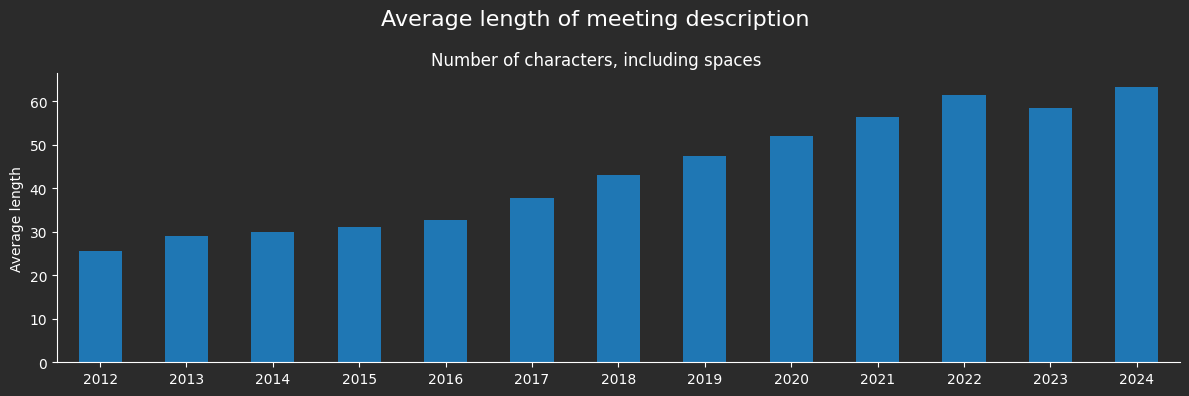

In [11]:
df["purpose_len"] = df["purpose"].apply(lambda x: len(x) if isinstance(x, str) else 0)

# Work out whether a meeting is on the first day of the month
df["week_day"] = df["date"].dt.day
df["first_day"] = df["week_day"] == 1

# Define the plot
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the pct of meetings on the first day
df.groupby("year")["purpose_len"].mean().plot.bar(ax=ax)

# Set the axis labels
ax.set_xlabel("")
ax.set_ylabel("Average length")

# Set title
plt.suptitle("Average length of meeting description", x=0.5, size=16)
ax.set_title("Number of characters, including spaces", ha="center", x=0.48)
# Rotate tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")


plt.tight_layout()
plt.savefig("img/records-length.png")

# Setup lobbyists table for parsing

In [26]:
# Create a separate org_record table to link the free text orgs to record ids
lobbyist_record = df[["reported_lobbyists_id", "record_id"]].dropna()

# Create a lobbyists table holding the free text to parse
lobbyists = df[["reported_lobbyists_id", "reported_lobbyists"]].drop_duplicates()
print(f"Unique lobbyist reports: {len(lobbyists)}")

# Rename columns to save my fingers
lobbyists.rename(
    columns={"reported_lobbyists_id": "id", "reported_lobbyists": "text"}, inplace=True
)

# We'll use the length of the record string as a heuristic later
lobbyists["text_len"] = lobbyists["text"].apply(len)

Unique lobbyist reports: 61241


<Axes: >

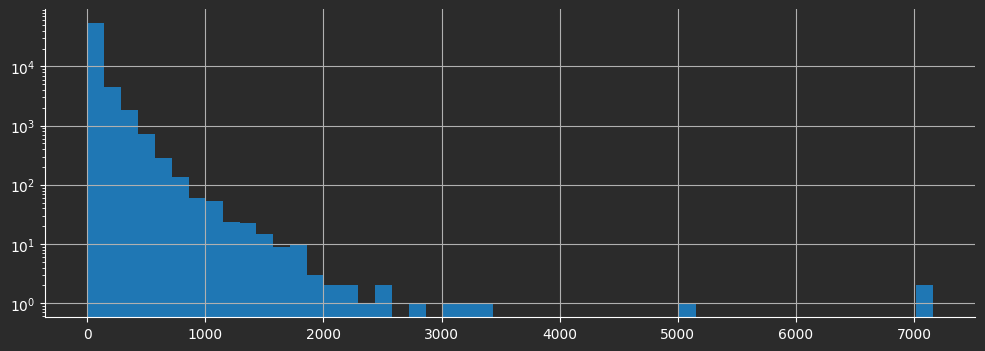

In [28]:
fig, ax = plt.subplots(figsize=(12, 4))
lobbyists["text_len"].hist(bins=50, log=True, ax=ax)

In [38]:
# Create a sample to experiment on
sample = lobbyists.sample(500, random_state=123)

# Set a line length for the below
ln = 80
# Take a look at 20 records to get a vibe, I sort by record length
for n, item in enumerate(sample.head(20).sort_values("text_len")["text"]):
    # C
    print(n, len(item), f"{item[:ln]}{"..." if len(item)>ln else ""}")

0 HESTA 5
1 Ageas UK 8
2 BT Wales 8
3 Alliance Trust 14
4 Prof Michael Depledge 21
5 The James Hutton Institute 26
6 Patient Safety Commissioner 27
7 Hampshire leaders roundtable 28
8 Marketing Manchester Members meeting 36
9 Torbj�_rn Sohlstr�_m, Ambassador of Sweden 42
10 Northern Ireland Council for Ethnic Minorities 46
11 Police Crime Commissioners and Chief Constables 47
12 Sheffield Hallam University degree apprenticeships roundtable 61
13 Etsy, Bespoke Binny, Swag And Tassel, CecilyVessey, ToriLoLeather, AsikarabyLaur 85
14 amnesty, Women4Libya, womankind Worldwide, Gender action for Peace and Security  86
15 Better Health Innovation Roundtable attendees; Apple, Amazon, Google, Tech UK, F 122
16 National Nuclear Laboratory, Nuclear Industry Association, Rolls-Royce, Babcock  154
17 Society of Motor Manufacturers and Traders, ADS Group, Association of British Ph 161
18 National Police Chief's Council, Association of Police and Crime Commissioners,  238
19 Agricultural Productivit

In [4]:
all_days = pd.date_range(df["date"].min(), df["date"].max())
missing_days = df.groupby("date").size().reindex(all_days).isna().resample("1Y").sum()
missing_days.index = missing_days.index.year
missing_days

/tmp/ipykernel_13814/627550480.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  missing_days = df.groupby('date').size().reindex(all_days).isna().resample('1Y').sum()


2012    329
2013    229
2014    168
2015    130
2016    121
2017     96
2018     59
2019     87
2020     41
2021     67
2022     57
2023     43
2024     14
dtype: int64

In [30]:
hash("your mum")

1841901837075293402

In [6]:
for i in orgs[orgs.organisation.str.contains("&")]["organisation"]:
    print(i)

Sir Daniel Bethlehem QC & Sir Jeffery Jowell QC
Lord Neuberger & Lady Hale
Lancaster & Morecambe College, Burley College, Accrington & Rossendale College, Blackburn College, Blackpool Sixth Form College, Nelson & Colne College, Myerscough College, Blackpool & The Fylde College, The Lancashire Colleges, Runshaw College
Total Politics, Hamilton Bradshaw, Cass Business School, Climate Cars Ltd, Ashbridge Experimental Learning, Make it Cheaper, Ernst & Young, Elegius, AFG Media
Aon Ltd, Ernst & Young
Deutsche Bank, Lloyds Banking Group, Accenture, Credit Suisse, Barclays, Barclays Business, Citibank, Capita Learning & Development, Prudential, Bank of America/Merill Lynch, Royal Bank of Scotland, Santander, HSBC, National Apprenticeship Service, Financial Skills Partnership
University and College Union, Association of Teachers & Lecturers, Association of School and College Leaders
German Industry UK, Siemens, KfW IPEX-Bank, Demag Cranes & Components, ThyssenKrupp UK, Robert Bosch, AKG UK, R

In [7]:
orgs["organisation"] = orgs["organisation"].str.strip()

In [10]:
import ollama

prompt = """
Extract people and organisations from the provided text.
The text is a free-text record from a database and may only contain a single result.
Return results as a single line of pipe (|) delimited text.
If there are no results, return the original text.
Do not provide any additional context or information.

Here is the text:
"""


# df = pd.read_csv('data/iw_uk.csv')
# df.head()
# %%
def generate(
    prompt,
    context=[],
    model="llama3.2:3b",
    num_ctx=1024,  # Set context low for speed
    num_predict=-1,
    temperature=0,
):
    response = ollama.generate(
        model=model,
        prompt=prompt,
        # system=system_prompt,
        context=context,
        options={
            # "num_ctx": num_ctx,
            "num_predict": num_predict,
            "temperature": temperature,
            "main_gpu": 0,
        },
    )
    return response["response"]


texts = orgs.sample(100, random_state=123)["organisation"]

from tqdm import tqdm

out = []
for text in tqdm(texts):
    x = generate(prompt + text)
    out.append([text, x])
out

100%|██████████| 100/100 [00:29<00:00,  3.36it/s]


[['Independent On Sunday', 'Independent | On | Sunday'],
 ['Meeting with John Diviney, CEO Welcome Break',
  'John Diviney|Welcome Break'],
 ['Lord Chief Justice', 'Lord Chief Justice'],
 ['East London CVS', 'East London CVS |'],
 ['Opportunity For Change, Community Interest Company',
  'Opportunity For Change | Community Interest Company'],
 ['Vysionics ITS Limited', 'Vysionics ITS Limited'],
 ['The National Society for the Prevention of Cruelty to Children',
  'National Society for the Prevention of Cruelty to Children |'],
 ['Trafford Council', 'Trafford Council'],
 ['Hubbub',
  'There are no people or organisations mentioned in the provided text.'],
 ['Nissan UK', 'Nissan UK'],
 ['National Association of Local Councils',
  'National Association of Local Councils |'],
 ['CPAG - Child Poverty Action group', 'CPAG | Child Poverty Action Group'],
 ["Sainsbury's; Premier Foods; Stobart Group Ltd; Coca-Cola; Agriculture and Horticulture Development Board; Dame Fiona Kendrick; Confederati

In [40]:
long_records = orgs[orgs.org_len > 6000]
bum = "Lord Mayor of London, Barbican Centre, Maritime London, Freemen's School, JLT Insurance Management (Guernsey), London Symphony Orchestra, St Olave Hart St Parochial Church Council, Barclays, House of Commons Maintenance Ltd, Moore Stephens, Specialist Schools & Academies Trust, Niche Solutions, NM Rothschild & Sons, Cornwall and Isles of Scilly Local Enterprise Partnership, Allied Irish Bank (GB), Gresham College, Accenture, Liberata, Deloitte, Crowe Clark Whitehill, International Centre for Financial Regulation, Euroclear SA/NV, Chartered Institute of Public Finance and Accountancy, Association of Chartered Certified Accountants, The Irish Society, Agilisys"
x = generate(prompt + bum)
x.split("|")

['Lord Mayor of London',
 'Barbican Centre',
 'Maritime London',
 "Freemen's School",
 'JLT Insurance Management (Guernsey)',
 'London Symphony Orchestra',
 'St Olave Hart St Parochial Church Council',
 'Barclays',
 'House of Commons Maintenance Ltd',
 'Moore Stephens',
 'Specialist Schools & Academies Trust',
 'Niche Solutions',
 'NM Rothschild & Sons',
 'Cornwall and Isles of Scilly Local Enterprise Partnership',
 'Allied Irish Bank (GB)',
 'Gresham College',
 'Accenture',
 'Liberata',
 'Deloitte',
 'Crowe Clark Whitehill',
 'International Centre for Financial Regulation',
 'Euroclear SA/NV',
 'Chartered Institute of Public Finance and Accountancy',
 'Association of Chartered Certified Accountants',
 'The Irish Society',
 'Agilisys']

In [35]:
y = long_records["organisation"].iloc[0]

In [36]:
x = "Ashford Council, Arun Council, Ashfield Council, Barnet Council, Amber Valley Council, Barnsley Council, Basildon Council, Bassetlaw Council, Bedford Council, Basingtonstoke Council, Bath and North East Somerset Council, London Borough of Barking and Dagenham, Babergh Distict Council, Adur and Worthing District Council, Bexley Council, Birmingham Council, Home Office"
len(y) - len(x)

6787

In [39]:
len(y.split(","))

355

In [20]:
df["tag"].value_counts()

tag
Health                      7709
Climate                     7050
Defence                     3661
Housing                     2815
Housing, Climate             106
Health, Defence               72
Health, Housing               32
Health, Climate               29
Housing, Defence              23
Defence, Climate              15
Health, Housing, Defence       1
Name: count, dtype: int64